<img src="https://gitlab.inf.unibz.it/earth_observation_public/eurac-openeo-examples/-/raw/main/python/aux_data/eurac_EO.png"
     alt="EURAC EO logo"
     style="float: left; margin-right: 10px; max-width: 300px" />

<img src="https://avatars.githubusercontent.com/u/63704085?s=400&u=5dc6c45b7d457ce6f303fbc612091cb2c133482f&v=4"
     alt="SAR2Cube logo"
     style="float: right; max-width: 200px" />
# SAR2Cube and openEO - SAR Differential Interferogram on-the-fly
Author michele.claus@eurac.edu

Date: 2023/10/31

## Useful links:

SAR2Cube website: https://sar2cube.projects.eurac.edu/

openEO main website: https://openeo.org/

openEO Python Client documentation: https://open-eo.github.io/openeo-python-client/index.html

Getting started guide for openEO with python: https://openeo.org/documentation/1.0/python/

## Topics
- Login to Eurac's openEO backend containing the SAR2Cube data sets
- Create an openEO process graph to compute the differential interferogram
- Create an openEO batch job and monitor it
- Download and visualize the results

## Import all the libraries and utilities functions
The ones included in the eo_utils.py file are needed for the ipyleaflet interactive map

Please check to have the latest `openeo` library. Please check here for the latest available version: https://pypi.org/project/openeo/

In [1]:
import os
import openeo
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

### Parameters
We usa a sample AOI in South Tyrol, Italy

In [2]:
spatial_extent = {'west': 10.66, 'east': 11.97, 'south': 46.29, 'north': 46.79}

Set the SAR processing parameters:

In [3]:
# Multi-look filter
range_looks   = 5
azimuth_looks = 1

# Geocoding
resolution = 10 # can be 10, 20 or 60 meters, it will be aligned with the Sentinel-2 grid
crs = 32632

openEO parameters:

In [3]:
# Datacube
collection      = "SAR2Cube_ASC_117_datacube"

# openEO Eurac back-end
openeoHost = "https://openeo.eurac.edu"

### Connect and authenticate with the Eurac openEO back-end

In [4]:
conn = openeo.connect(openeoHost).authenticate_oidc(client_id="openEO_PKCE")
bands = ["phase","grid_lon","grid_lat","i_VV","q_VV","i_VH","q_VH"]
s1_slc_cube = conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands)

Visit https://edp-portal.eurac.edu/auth/realms/edp/device?user_code=WCDA-LILX 📋 to authenticate.

[###################################--] ✅ Authorized successfully

Authenticated using device code flow.


### We will compute the differential interferogram between two dates selected below

In [6]:
first_date = np.datetime64("2019-01-02")
second_date = np.datetime64("2019-01-08")
first_temporal_extent = [str(first_date),str(first_date + np.timedelta64(1, "D"))]
second_temporal_extent = [str(second_date),str(second_date + np.timedelta64(1, "D"))]

first_slc_cube = s1_slc_cube.filter_temporal(first_temporal_extent).reduce_dimension(dimension="DATE",reducer="mean")
second_slc_cube = s1_slc_cube.filter_temporal(second_temporal_extent).reduce_dimension(dimension="DATE",reducer="mean")

In [7]:
phase_mst = first_slc_cube.filter_bands(bands=["phase"]).rename_labels(dimension="bands",target=["phase_mst"],source=["phase"])
phase_slv = second_slc_cube.filter_bands(bands=["phase"]).rename_labels(dimension="bands",target=["phase_slv"],source=["phase"])

phases = phase_mst.merge_cubes(phase_slv)

phase_mst_band = phases.band("phase_mst")
phase_slv_band = phases.band("phase_slv")
phases_diff = phase_mst_band - phase_slv_band

In [8]:
from openeo.processes import cos, sin
i_ifg_2 = phases_diff.apply(lambda x: cos(x) ).add_dimension(name="bands",type="bands",label="i_IFG_2")
q_ifg_2 = phases_diff.apply(lambda x: sin(x) ).add_dimension(name="bands",type="bands",label="q_IFG_2")

ifg_2 = q_ifg_2.merge_cubes(i_ifg_2)

In [9]:
first_cube_renamed = first_slc_cube.rename_labels(dimension="bands",source=["i_VV","q_VV"],target=["i_VV_mst","q_VV_mst"])
second_cube_renamed = second_slc_cube.rename_labels(dimension="bands",source=["i_VV","q_VV"],target=["i_VV_slv","q_VV_slv"])

first_second_slc_cube = first_cube_renamed.merge_cubes(second_cube_renamed)
first_second_slc_cube

### Real part of the interferogram

In [10]:
from openeo.processes import array_element

def compute_real_part(data):
    i_VV_mst = data.array_element(label="i_VV_mst")
    i_VV_slv = data.array_element(label="i_VV_slv")
    q_VV_mst = data.array_element(label="q_VV_mst")
    q_VV_slv = data.array_element(label="q_VV_slv")
    
    return i_VV_mst * i_VV_slv + q_VV_mst * q_VV_slv

real_part_ifg = first_second_slc_cube.reduce_dimension(dimension="bands",reducer=compute_real_part)
real_part_ifg = real_part_ifg.add_dimension(name="bands",type="bands",label="i_IFG")

### Imaginary part of the interferogram

In [11]:
def compute_imag_part(data):
    i_VV_mst = data.array_element(label="i_VV_mst")
    i_VV_slv = data.array_element(label="i_VV_slv")
    q_VV_mst = data.array_element(label="q_VV_mst")
    q_VV_slv = data.array_element(label="q_VV_slv")
    
    return q_VV_mst * i_VV_slv - i_VV_mst * q_VV_slv

imag_part_ifg = first_second_slc_cube.reduce_dimension(dimension="bands",reducer=compute_imag_part)
imag_part_ifg = imag_part_ifg.add_dimension(name="bands",type="bands",label="q_IFG")

In [12]:
ifg_phases_diff = imag_part_ifg.merge_cubes(real_part_ifg).merge_cubes(ifg_2)

### Real part of the differential interferogram

In [13]:
def compute_real_part_diff_ifg(data):
    i_IFG = data.array_element(label="i_IFG")
    q_IFG = data.array_element(label="q_IFG")
    i_IFG_2 = data.array_element(label="i_IFG_2")
    q_IFG_2 = data.array_element(label="q_IFG_2")
    
    return i_IFG * i_IFG_2 - q_IFG * q_IFG_2

real_part_diff_ifg = ifg_phases_diff.reduce_dimension(dimension="bands",reducer=compute_real_part_diff_ifg)
real_part_diff_ifg = real_part_diff_ifg.add_dimension(name="bands",type="bands",label="i_IFG_DIF")

### Imaginary part of the differential interferogram

In [14]:
def compute_imag_part_diff_ifg(data):
    i_IFG = data.array_element(label="i_IFG")
    q_IFG = data.array_element(label="q_IFG")
    i_IFG_2 = data.array_element(label="i_IFG_2")
    q_IFG_2 = data.array_element(label="q_IFG_2")
    
    return q_IFG * i_IFG_2 + i_IFG * q_IFG_2

imag_part_diff_ifg = ifg_phases_diff.reduce_dimension(dimension="bands",reducer=compute_imag_part_diff_ifg)
imag_part_diff_ifg = imag_part_diff_ifg.add_dimension(name="bands",type="bands",label="q_IFG_DIF")

In [15]:
from openeo.processes import arctan2
diff_ifg_complex = real_part_diff_ifg.merge_cubes(imag_part_diff_ifg).aggregate_spatial_window(reducer="mean",size=[range_looks,azimuth_looks])

def phase_from_complex(data):
    real = data.array_element(label="i_IFG_DIF")
    imag = data.array_element(label="q_IFG_DIF")
    
    return arctan2(imag, real)

diff_ifg_phase = diff_ifg_complex.reduce_dimension(dimension="bands",reducer=phase_from_complex)
diff_ifg_phase = diff_ifg_phase.add_dimension(name="bands",type="bands",label="IFG_DIF")

### Geocoding

In [16]:
lat_lon_grids = s1_slc_cube.filter_bands(["grid_lon","grid_lat"]).reduce_dimension(dimension="DATE",reducer="mean")
lat_lon_grids_ML = lat_lon_grids.aggregate_spatial_window(size=[range_looks,azimuth_looks],reducer="mean")

diff_ifg_phase = diff_ifg_phase.merge_cubes(lat_lon_grids_ML)

args_geocoding = {"resolution":resolution,"crs":crs}
diff_ifg_phase_geocoded = diff_ifg_phase.process("geocode",args_geocoding, data=diff_ifg_phase)

diff_ifg_phase_geocoded_tiff = diff_ifg_phase_geocoded.save_result(format="GTiff")

### Create a batch job and start it

In [17]:
job = diff_ifg_phase_geocoded_tiff.create_job(title="Differential_interferogram")
job.start_job()

<BatchJob job_id='39b5afdc-dfa0-4502-ad77-5d167b0ef518'>

In [21]:
job.status()

'finished'

In [22]:
if job.status()=="finished":
    results = job.get_results()
    results.download_files("diff_ifg_result")

### Open the result and visualiza it

In [25]:
import rioxarray
data = rioxarray.open_rasterio("diff_ifg_result/result.tiff")
data

<xarray.DataArray (band: 1, y: 5827, x: 10208)>
[59482016 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6.267e+05 6.267e+05 ... 7.288e+05 7.288e+05
  * y            (y) float64 5.186e+06 5.186e+06 ... 5.128e+06 5.128e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        3.141592502594
    STATISTICS_MEAN:           0.14048362417774
    STATISTICS_MINIMUM:        -3.141592502594
    STATISTICS_STDDEV:         1.7809806334194
    STATISTICS_VALID_PERCENT:  92.57
    _FillValue:                nan
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 IFG_DIF

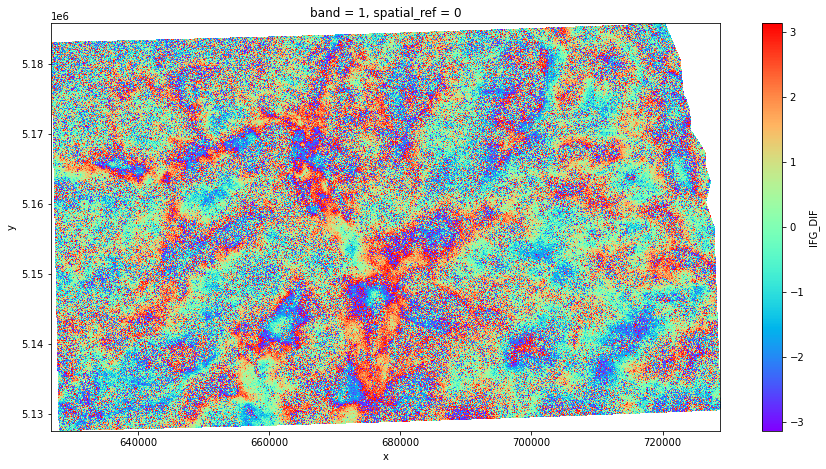

In [37]:
data[0].plot.imshow(figsize=(15,7.5),cmap="rainbow")